<div style="overflow:auto;">
    <div style="float:left; margin-right:10px;">
        <img width='120' height='120' src='https://cityme.novaims.unl.pt/images/footer/novaims.png'>
    </div>
    <div>
        <h4>This project is conducted as part of the "Machine Learning Operations" course, a component of the Master's program in Data Science and Advanced Analytics at the Nova Information Management School.</h4>  
        <h1 style="background-color: SeaGreen; color: white; display: inline-block;"><b>Machine Learning Operations Project</b></h1>
    </div>
</div>
- Nicolau Dulea, 20230544
- Pedro Catarro, 20230463
- Rodrigo Silva 20230536
</div> 

***
### Importing necessary libraries
***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import logging
import os
from typing import Any, Optional
from ydata_profiling.expectations_report import ExpectationsReport
from visions import VisionsTypeset
import hopsworks
from datetime import datetime
import hsfs
from great_expectations.core import ExpectationSuite
from hsfs.feature_group import FeatureGroup
from ydata_profiling.config import Settings
from ydata_profiling.model import BaseDescription, expectation_algorithms
from ydata_profiling.model.handler import Handler
from ydata_profiling.utils.dataframe import slugify
from great_expectations.checkpoint import SimpleCheckpoint
import torch.nn as nn
import random
import pickle
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
from ydata_profiling import ProfileReport
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
import great_expectations as gx
import yaml
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import mlflow
from great_expectations.core.expectation_configuration import ExpectationConfiguration
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

In [5]:
#!pip install hopsworks   

# **<p style="color:Blue;">About The Dataset:</p>**

- **Age**: Age of the patient.
- **Sex**: Sex of the patient.
- **CP**: Chest pain type:
  - **0** = Typical Angina
  - **1** = Atypical Angina
  - **2** = Non-anginal Pain
  - **3** = Asymptomatic
- **TRTBPS**: Resting blood pressure (mm Hg).
- **Chol**: Cholesterol (mg/dl).
- **FBS**: Fasting blood sugar > 120 mg/dl:
  - **1** = True
  - **0** = False
- **RestECG**: Resting electrocardiographic results:
  - **0** = Normal
  - **1** = ST-T wave abnormality
  - **2** = Left ventricular hypertrophy
- **Thalach**: Maximum heart rate achieved.
- **Oldpeak**: ST depression induced by exercise.
- **SLP**: Slope of the peak exercise ST segment.
- **CAA**: Number of major vessels (0-4) colored by fluoroscopy.
- **Thall**: Thallium Stress Test result:
  - **0** = Normal
  - **1** = Fixed defect
  - **2** = Reversible defect
- **EXNG**: Exercise induced angina:
  - **1** = Yes
  - **0** = No
- **Output**: Target variable indicating presence of heart disease.


In [7]:
df = pd.read_csv("heart.csv")
df.to_csv('df_before_EDA')  

In [8]:
df.shape

(303, 14)

In [9]:
df.head()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1

In [10]:
df.value_counts()

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  caa  thall  output
38   1    2   138     175   0    1        173       0     0.0      2    4    2      1         2
59   1    0   110     239   0    0        142       1     1.2      1    1    3      0         1
          2   126     218   1    1        134       0     2.2      1    1    1      0         1
          1   140     221   0    1        164       1     0.0      2    0    2      1         1
          0   170     326   0    0        140       1     3.4      0    0    3      0         1
                                                                                             ..
51   1    2   94      227   0    1        154       1     0.0      2    1    3      1         1
          0   140     299   0    1        173       1     1.6      2    0    3      0         1
                      298   0    1        122       1     4.2      1    3    3      0         1
                      261   0    0        186

In [11]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

unique count
age                 41
sex                  2
cp                   4
trtbps              49
chol               152
fbs                  2
restecg              3
thalachh            91
exng                 2
oldpeak             40
slp                  3
caa                  5
thall                4
output               2

In [12]:
categorical_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
continuous_cols = ["age","trtbps","chol","thalachh","oldpeak"]
target_col = ["output"]
print("The categorial cols are : ", categorical_cols)
print("The continuous cols are : ", continuous_cols)
print("The target variable is :  ", target_col)

The categorial cols are :  ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']
The continuous cols are :  ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
The target variable is :   ['output']


In [13]:
def check_balance(df, target_col, threshold=0.1):
    """
    Check if the dataset is balanced or unbalanced.
    
    Parameters:
    - df: pandas DataFrame containing the dataset.
    - target_column: the name of the column containing the target classes.
    - threshold: the maximum allowable difference in class proportions to consider the dataset balanced.
    
    Returns:
    - A string indicating whether the dataset is balanced or unbalanced.
    - Prints the class distribution and a bar plot of the class counts.
    """
    # Count the instances of each class
    class_counts = df[target_col].value_counts()
    
    # Calculate the proportion of each class
    class_proportions = df[target_col].value_counts(normalize=True)
    
    # Determine the difference between the maximum and minimum class proportions
    max_proportion = class_proportions.max()
    min_proportion = class_proportions.min()
    difference = max_proportion - min_proportion
    
    # Print class counts and proportions
    print("Class Counts:")
    print(class_counts)
    print("\nClass Proportions:")
    print(class_proportions)
    
    # Plot the class counts
    class_counts.plot(kind='bar')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()
    
    # Determine if the dataset is balanced or unbalanced
    if difference > threshold:
        return "The dataset is unbalanced."
    else:
        return "The dataset is balanced."

Class Counts:
output
1         165
0         138
dtype: int64

Class Proportions:
output
1         0.544554
0         0.455446
dtype: float64


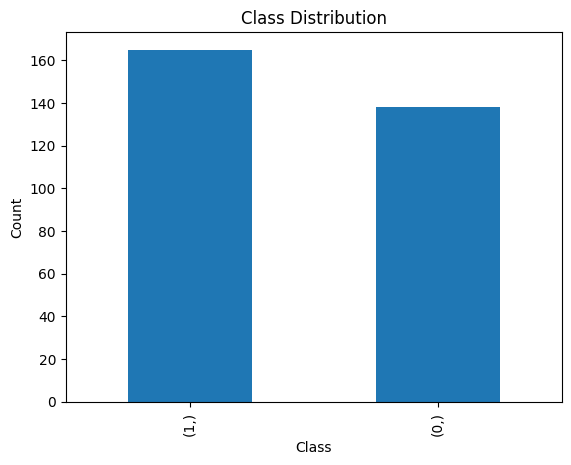

'The dataset is balanced.'

In [14]:
check_balance(df, target_col, threshold=0.1)

In [15]:
df.isnull().sum()

age         0
sex         0
cp          0
trtbps      0
chol        0
fbs         0
restecg     0
thalachh    0
exng        0
oldpeak     0
slp         0
caa         0
thall       0
output      0
dtype: int64

2024-06-29 20:45:59,302 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-29 20:45:59,316 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-29 20:45:59,374 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-29 20:45:59,389 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-29 20:45:59,445 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates

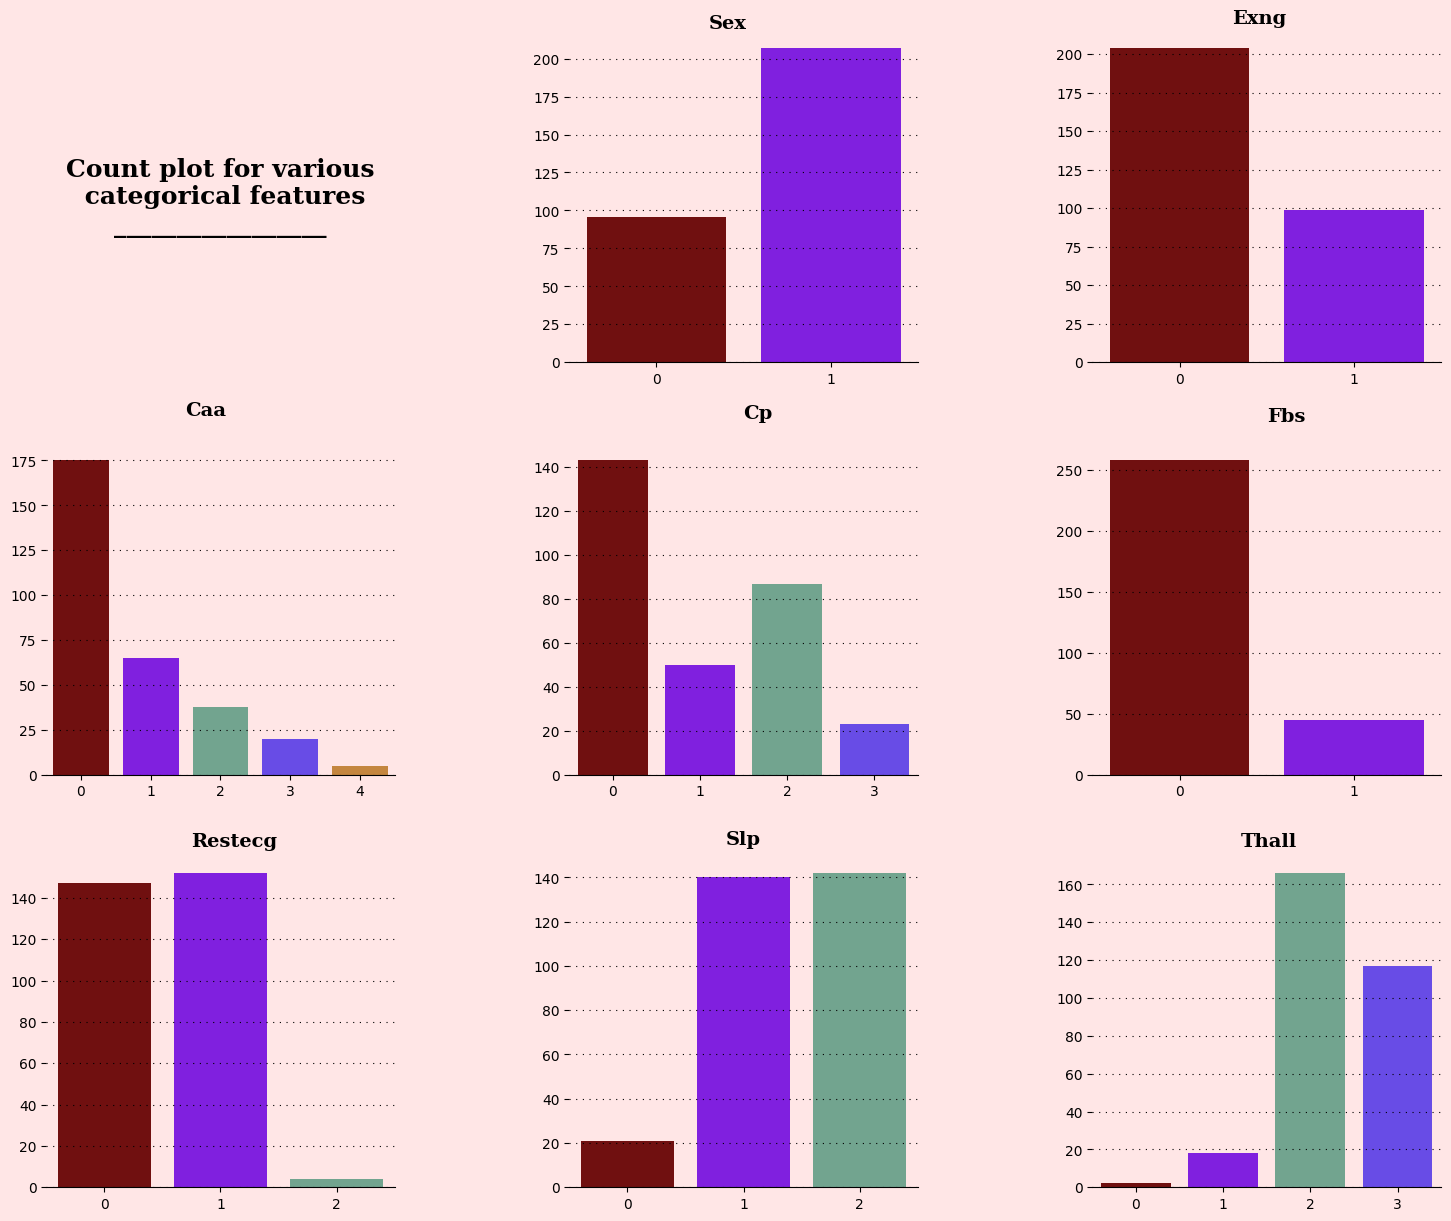

In [16]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(3,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0])
ax7 = fig.add_subplot(gs[2,1])
ax8 = fig.add_subplot(gs[2,2])

background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 
ax6.set_facecolor(background_color) 
ax7.set_facecolor(background_color) 
ax8.set_facecolor(background_color) 

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot for various\n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Sex count
ax1.text(0.3, 220, 'Sex', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1,data=df,x='sex',palette=color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Exng count
ax2.text(0.3, 220, 'Exng', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2,data=df,x='exng',palette=color_palette)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Caa count
ax3.text(1.5, 200, 'Caa', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3,data=df,x='caa',palette=color_palette)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Cp count
ax4.text(1.5, 162, 'Cp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax4,data=df,x='cp',palette=color_palette)
ax4.set_xlabel("")
ax4.set_ylabel("")

# Fbs count
ax5.text(0.5, 290, 'Fbs', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax5,data=df,x='fbs',palette=color_palette)
ax5.set_xlabel("")
ax5.set_ylabel("")

# Restecg count
ax6.text(0.75, 165, 'Restecg', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax6.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax6,data=df,x='restecg',palette=color_palette)
ax6.set_xlabel("")
ax6.set_ylabel("")

# Slp count
ax7.text(0.85, 155, 'Slp', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax7.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax7,data=df,x='slp',palette=color_palette)
ax7.set_xlabel("")
ax7.set_ylabel("")

# Thall count
ax8.text(1.2, 180, 'Thall', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax8.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax8,data=df,x='thall',palette=color_palette)
ax8.set_xlabel("")
ax8.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)
    ax6.spines[s].set_visible(False)
    ax7.spines[s].set_visible(False)
    ax8.spines[s].set_visible(False)

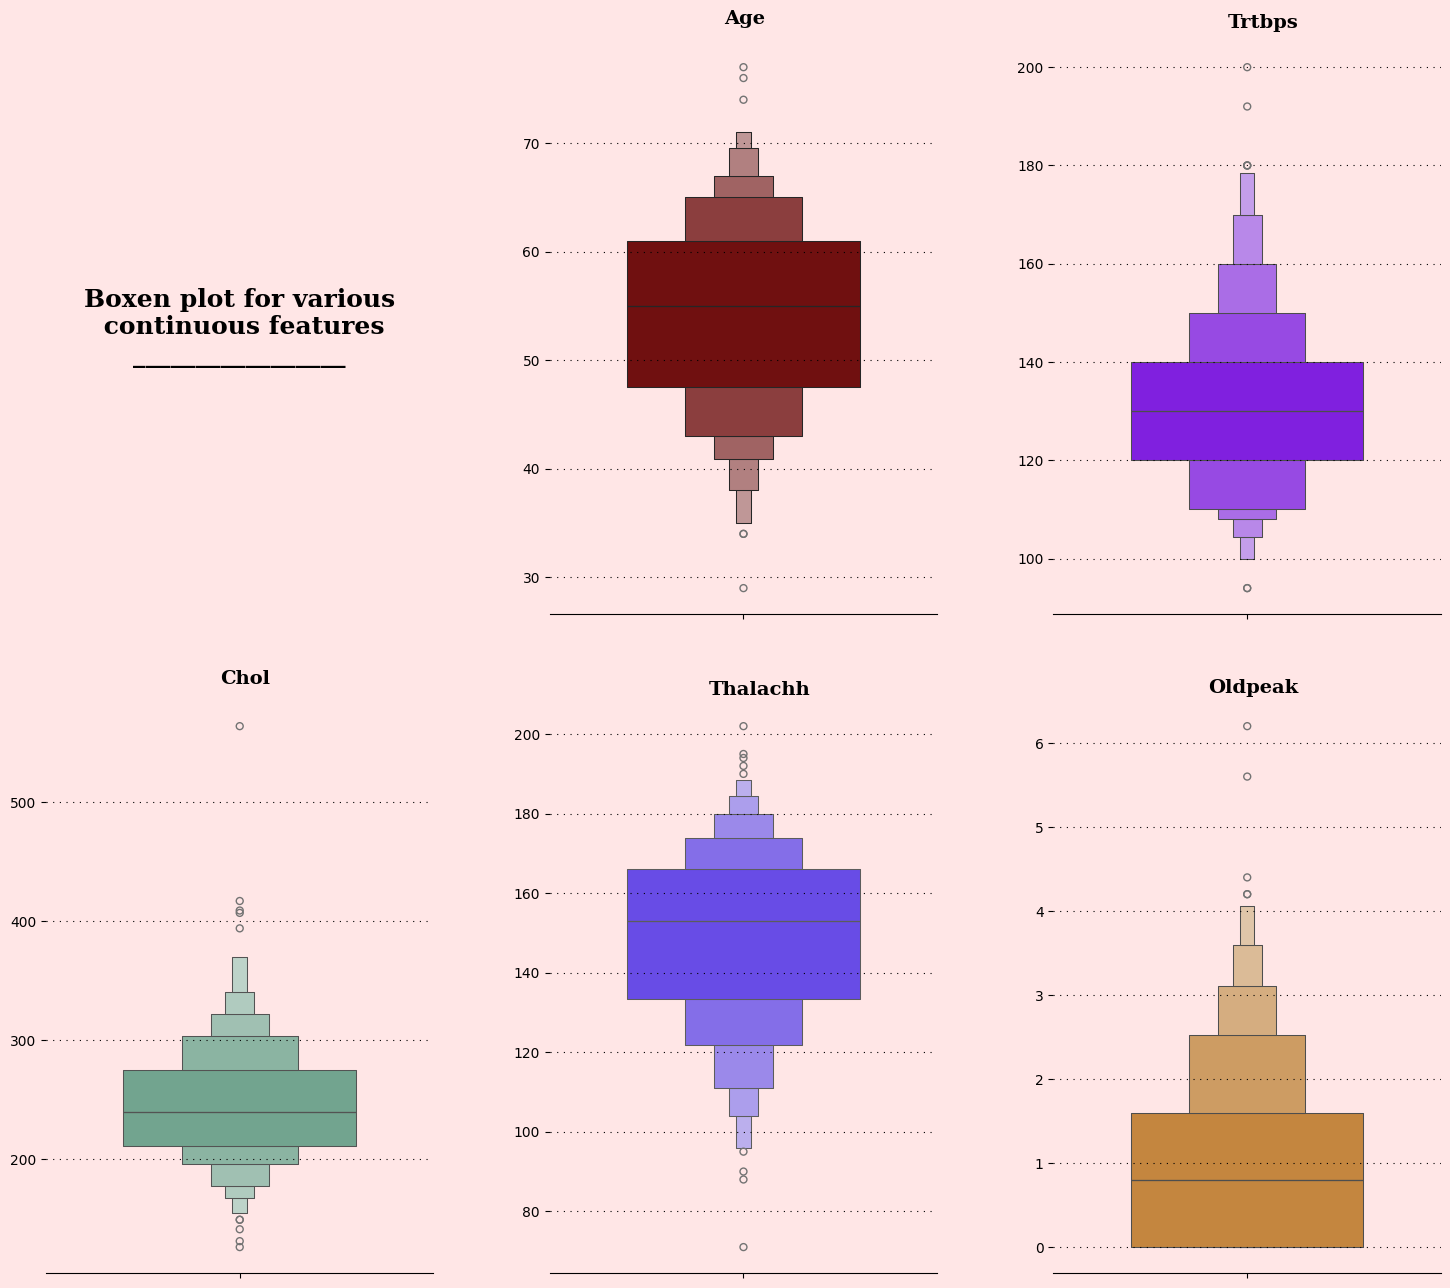

In [17]:
fig = plt.figure(figsize=(18,16))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 
ax2.set_facecolor(background_color) 
ax3.set_facecolor(background_color) 
ax4.set_facecolor(background_color) 
ax5.set_facecolor(background_color) 

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Boxen plot for various\n continuous features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Age 
ax1.text(-0.05, 81, 'Age', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax1,y=df['age'],palette=["#800000"],width=0.6)
ax1.set_xlabel("")
ax1.set_ylabel("")

# Trtbps 
ax2.text(-0.05, 208, 'Trtbps', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax2,y=df['trtbps'],palette=["#8000ff"],width=0.6)
ax2.set_xlabel("")
ax2.set_ylabel("")

# Chol 
ax3.text(-0.05, 600, 'Chol', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax3,y=df['chol'],palette=["#6aac90"],width=0.6)
ax3.set_xlabel("")
ax3.set_ylabel("")

# Thalachh 
ax4.text(-0.09, 210, 'Thalachh', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax4.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax4,y=df['thalachh'],palette=["#5833ff"],width=0.6)
ax4.set_xlabel("")
ax4.set_ylabel("")

# oldpeak 
ax5.text(-0.1, 6.6, 'Oldpeak', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax5.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.boxenplot(ax=ax5,y=df['oldpeak'],palette=["#da8829"],width=0.6)
ax5.set_xlabel("")
ax5.set_ylabel("")

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)
    ax4.spines[s].set_visible(False)
    ax5.spines[s].set_visible(False)

In [18]:
df.agg(['min', 'max']) #check the range values

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
min   29    0   0      94   126    0        0        71     0      0.0    0   
max   77    1   3     200   564    1        2       202     1      6.2    2   

     caa  thall  output  
min    0      0       0  
max    4      3       1

In [19]:
# Group by 'sex' and calculate the range for each variable
range_values = df.groupby('sex').agg({
    'age': ['min', 'max'],
    'cp': ['min', 'max'],
    'trtbps': ['min', 'max'],
    'chol': ['min', 'max'],
    'fbs': ['min', 'max'],
    'restecg': ['min', 'max'],
    'thalachh': ['min', 'max'],
    'oldpeak': ['min', 'max'],
    'slp': ['min', 'max'],
    'caa': ['min', 'max'],
    'thall': ['min', 'max'],
    'exng': ['min', 'max'],
    'output': ['min', 'max']
})

# Print the range values
range_values

age      cp     trtbps      chol      fbs      ... slp     caa     thall  \
    min max min max    min  max  min  max min max  ... min max min max   min   
sex                                                ...                         
0    34  76   0   3     94  200  141  564   0   1  ...   0   2   0   3     0   
1    29  77   0   3     94  192  126  353   0   1  ...   0   2   0   4     0   

        exng     output      
    max  min max    min max  
sex                          
0     3    0   1      0   1  
1     3    0   1      0   1  

[2 rows x 26 columns]

## Heart attacks can happen to anyone, but statistically they happen to people of a certain age. Data from the American Heart Association shows the average age of a person at the time of their first heart attack in the United States is 65.5 years for males and 72 for females.
https://nortonhealthcare.com/news/average-age-heart-attack/#:~:text=Heart%20attacks%20can%20happen%20to,However%2C%20those%20numbers%20are%20changing.

https://www.medicalnewstoday.com/articles/270644#ranges - blood pressure// Expected	< 120 mm Hg
A doctor will diagnose hypertension right away if your blood pressure is extremely high (higher than 200/120 mmHg). If your blood pressure is higher than 180 mmHg, then your doctor will be able to diagnose you with hypertension after just two visits over a short period of time.
The record of the world was 370 mmHg..

https://www.ncbi.nlm.nih.gov/books/NBK542294/#:~:text=Optimal%3A%20less%20than%20100%20mg,160%20to%20189%20mg%2FdL - Cholestoral
Normal: Less than 200 mg/dL.
Borderline high: 200 to 239 mg/dL.
High: At or above 240 mg/dL.

People with this rare type of FH usually have LDL cholesterol levels greater than 300 mg/dL for adults and above 400-500 mg/dL for children are at increased risk for heart attacks and coronary artery disease at a very young age.
https://www.webmd.com/cholesterol-management/homozygous-familial-hypercholesterolemia

https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979#:~:text=A%20normal%20resting%20heart%20rate%20for%20adults%20ranges%20from%2060,function%20and%20better%20cardiovascular%20fitness. - thalachh
A normal resting heart rate for adults ranges from 60 to 100 beats per minute.

The fastest human ventricular conduction rate recorded to this day is a conducted tachyarrhythmia with ventricular rate of 600 beats per minute.

The maximum rate is based on your age, as subtracted from 220. So for a 50-year-old, maximum heart rate is 220 minus 50, or 170 beats per minute.
https://en.wikipedia.org/wiki/Heart_rate#:~:text=The%20fastest%20human%20ventricular%20conduction,heart%20rate%20of%20a%20mouse.

slp: the slope of the peak exercise ST segment

0 = unsloping

1 = flat

2 = downsloping

https://www.webmd.com/heart-disease/high-cholesterol-healthy-heart - caa
The major blood vessels connected to your heart are the aorta, the superior vena cava, the inferior vena cava, the pulmonary artery (which takes oxygen-poor blood from the heart to the lungs where it is oxygenated), the pulmonary veins (which bring oxygen-rich blood from the lungs to the heart), and the coronary arteries (which supply blood to the heart muscle).

thall - Thalium Stress Test result
tell you about the flow of blood to your heart through your coronary arteries.
thall : thalassemia

0 = null

1 = fixed defect

2 = normal

3 = reversable defect

output: diagnosis of heart disease (angiographic disease status)
0: < 50% diameter narrowing. less chance of heart disease

1: > 50% diameter narrowing. more chance of heart disease




oldpeak-ST segment depression less than 0.5 mm is accepted in all leads.
It is significant if it is more than 1 mm in V5-V6, or 1.5 mm in AVF

2024-06-29 20:46:03,859 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-29 20:46:03,875 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


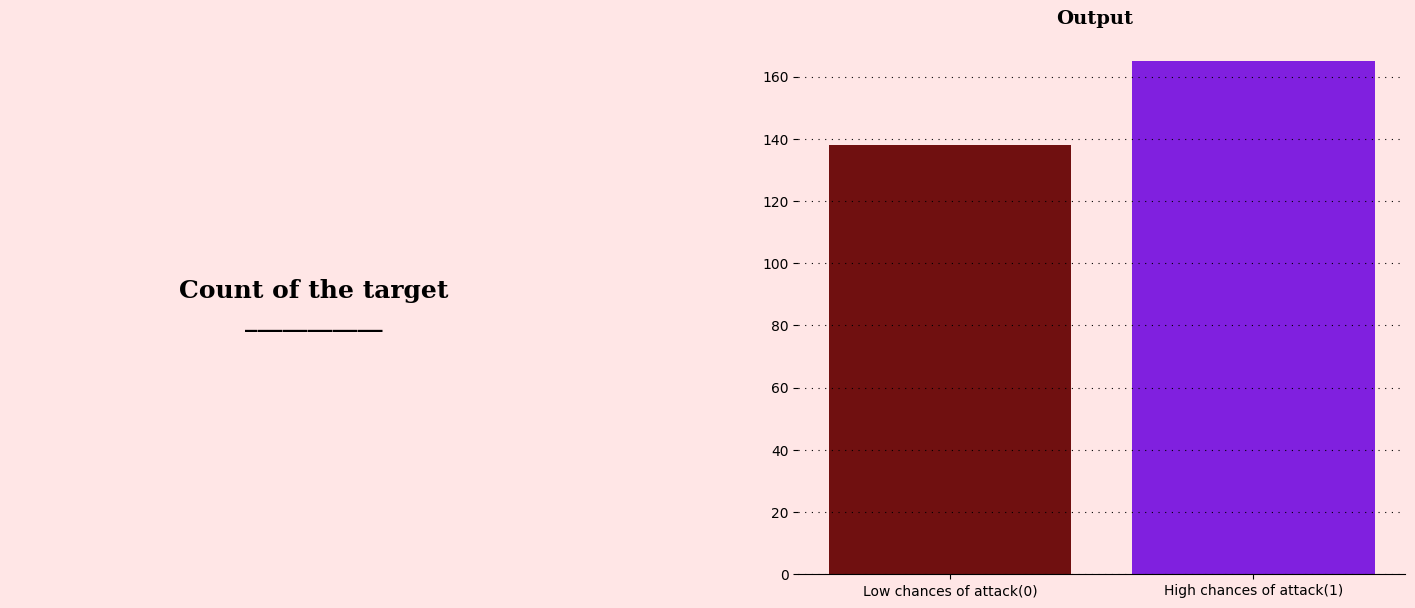

In [28]:
fig = plt.figure(figsize=(18,7))
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.3, hspace=0.15)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])

background_color = "#ffe6e6"
color_palette = ["#800000","#8000ff","#6aac90","#5833ff","#da8829"]
fig.patch.set_facecolor(background_color) 
ax0.set_facecolor(background_color) 
ax1.set_facecolor(background_color) 

# Title of the plot
ax0.text(0.5,0.5,"Count of the target\n___________",
        horizontalalignment = 'center',
        verticalalignment = 'center',
        fontsize = 18,
        fontweight='bold',
        fontfamily='serif',
        color='#000000')

ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.tick_params(left=False, bottom=False)

# Target Count
ax1.text(0.35,177,"Output",fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1, data=df, x = 'output',palette = color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticklabels(["Low chances of attack(0)","High chances of attack(1)"])

ax0.spines["top"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(False)

In [29]:
df_corr = df[continuous_cols].corr().transpose()
df_corr

age    trtbps      chol  thalachh   oldpeak
age       1.000000  0.279351  0.213678 -0.398522  0.210013
trtbps    0.279351  1.000000  0.123174 -0.046698  0.193216
chol      0.213678  0.123174  1.000000 -0.009940  0.053952
thalachh -0.398522 -0.046698 -0.009940  1.000000 -0.344187
oldpeak   0.210013  0.193216  0.053952 -0.344187  1.000000

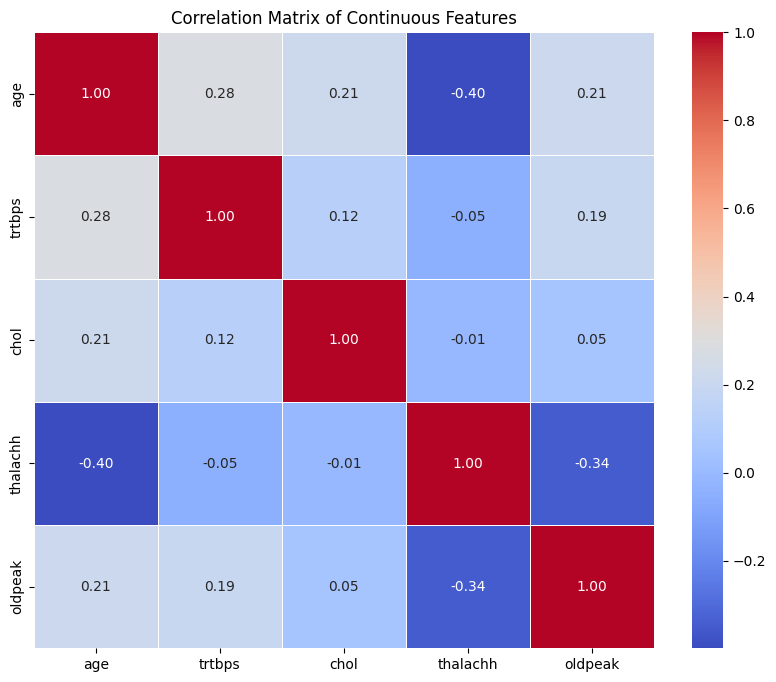

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Continuous Features')
plt.show()

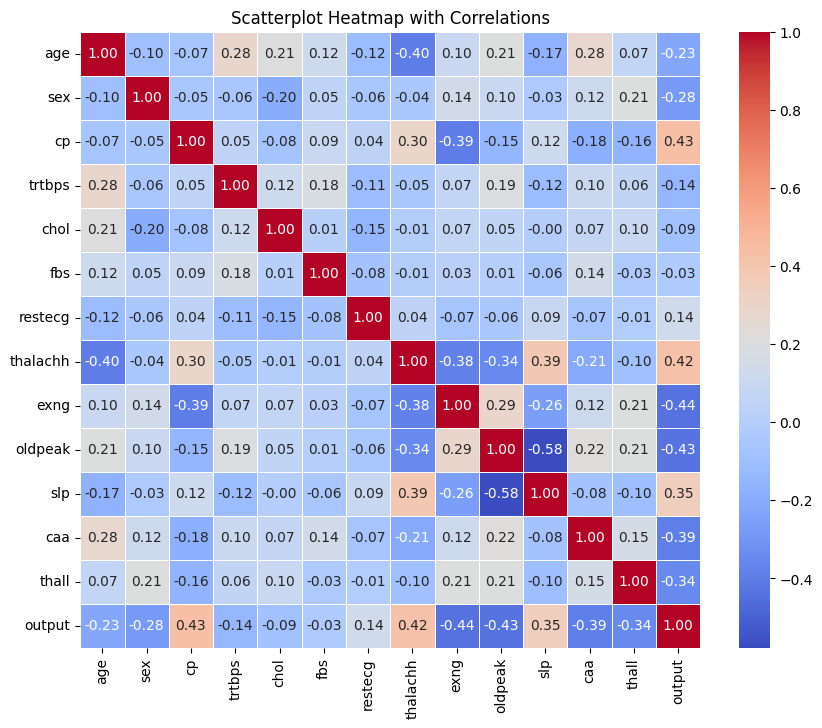

In [31]:
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Scatterplot Heatmap with Correlations')
plt.show()

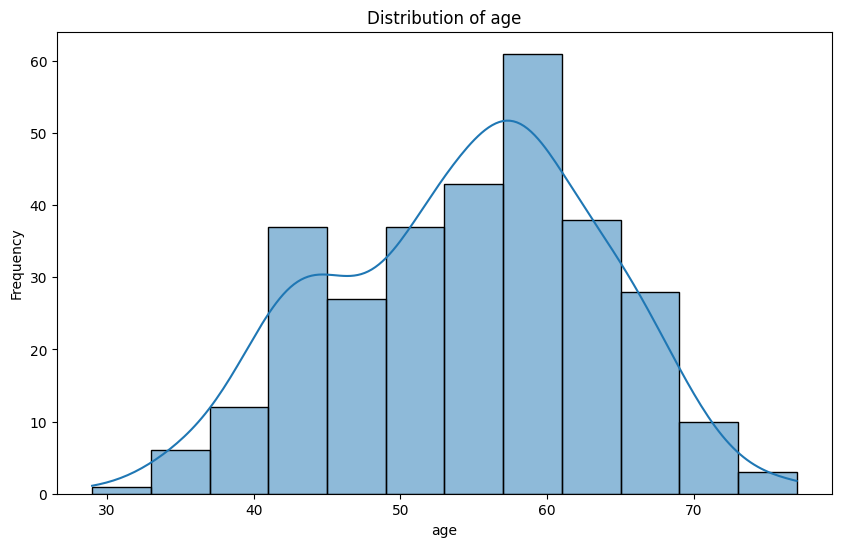

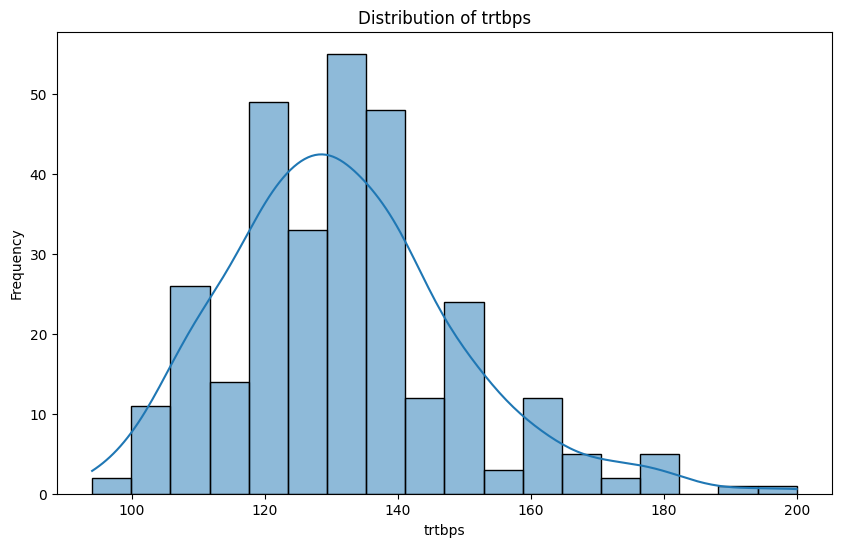

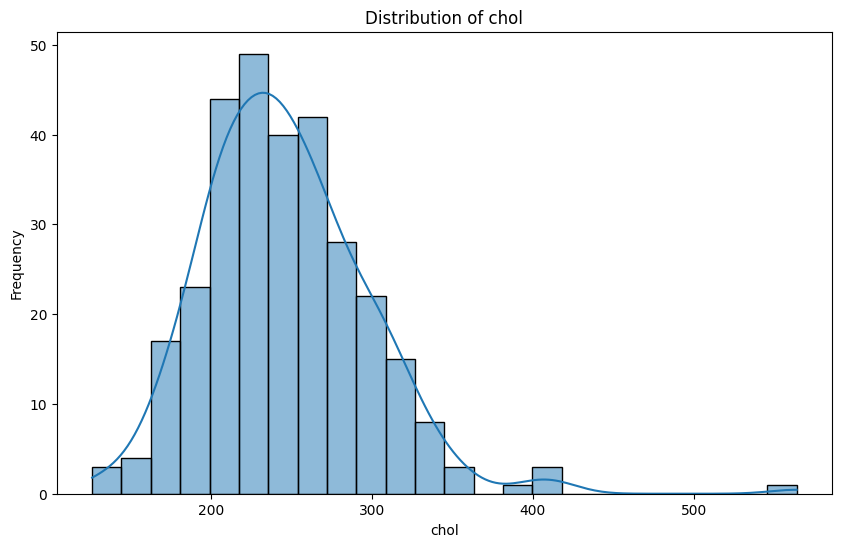

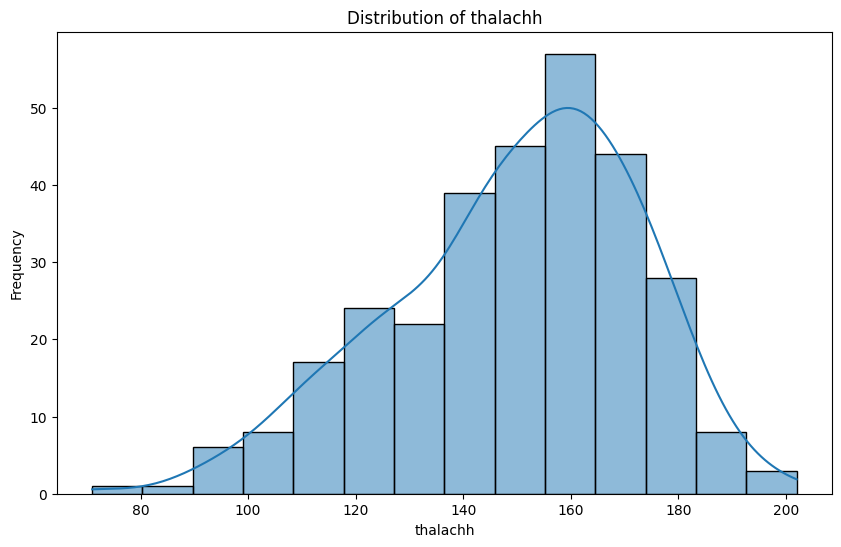

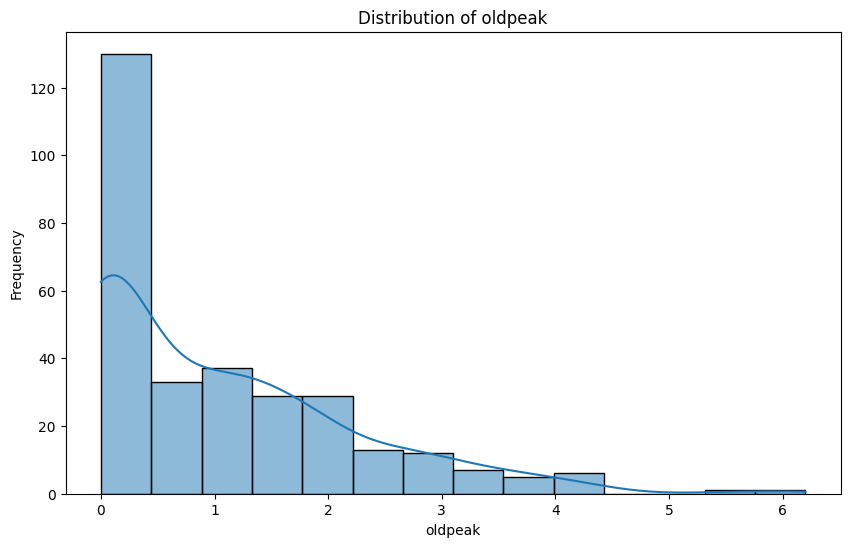

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your continuous columns
continuous_cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

# Loop through continuous columns and create a separate graph for each
for col in continuous_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

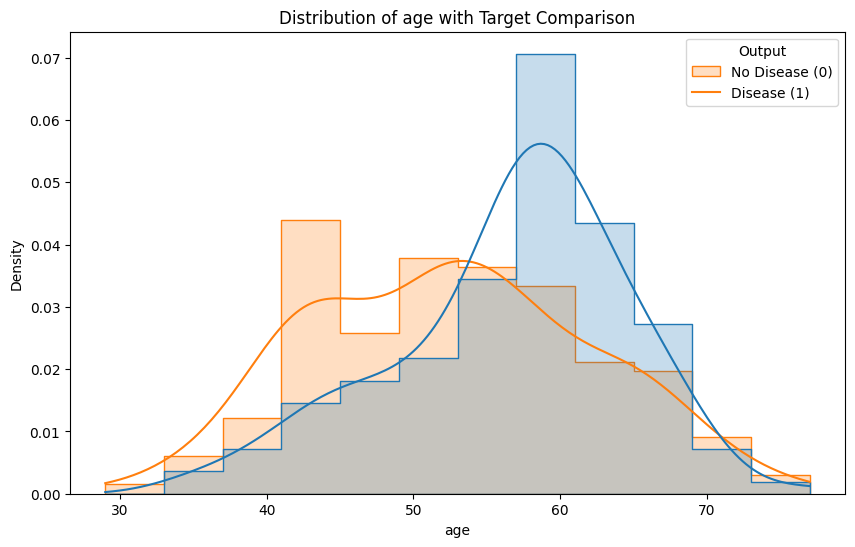

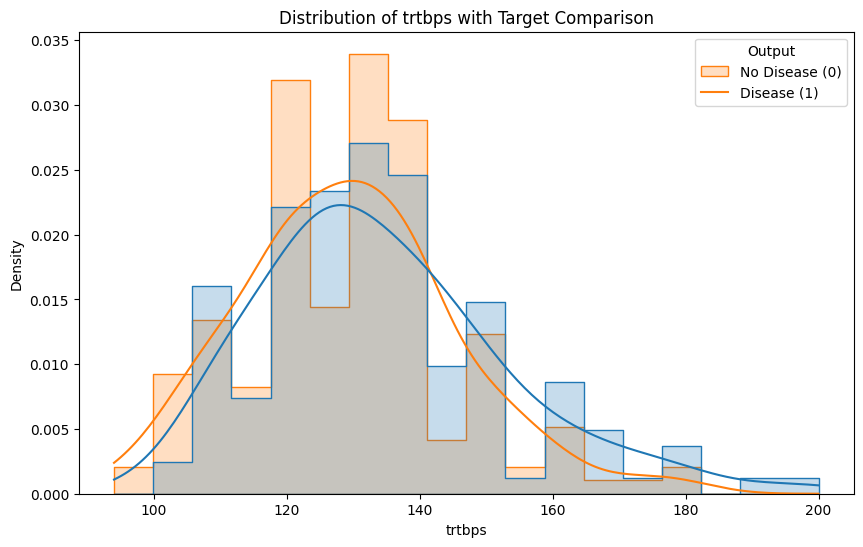

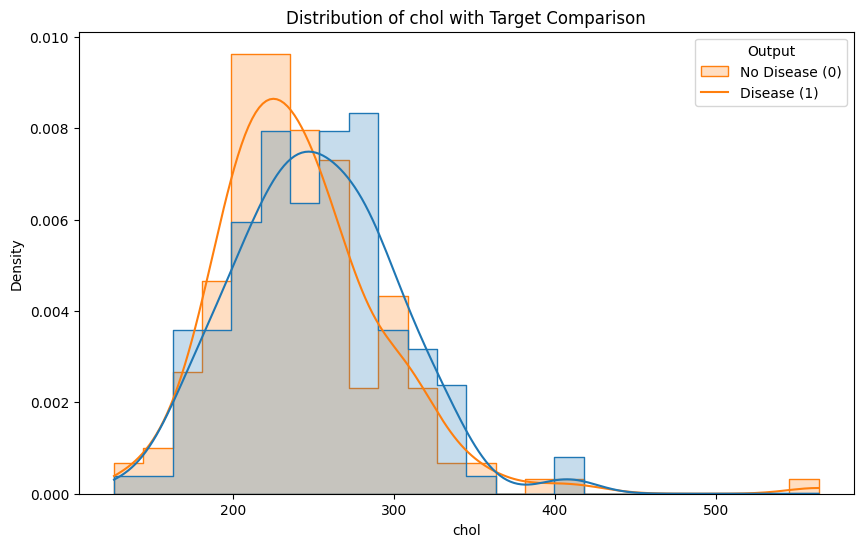

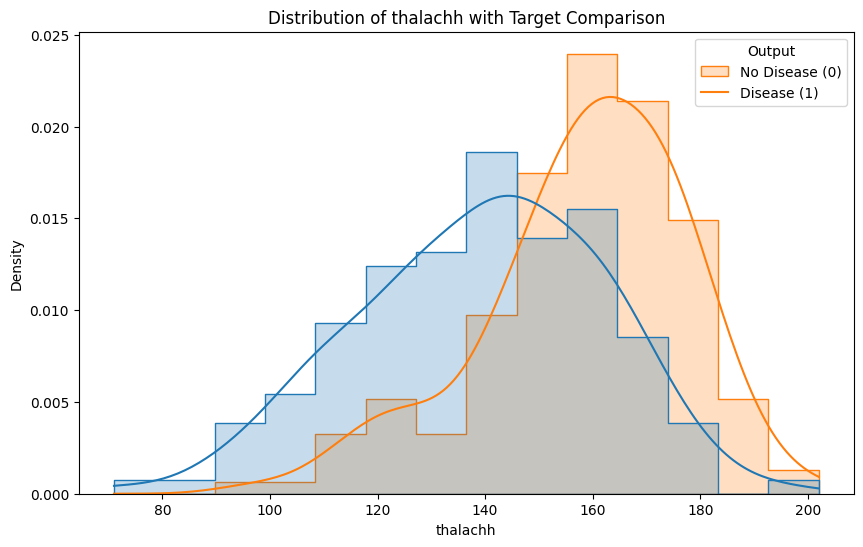

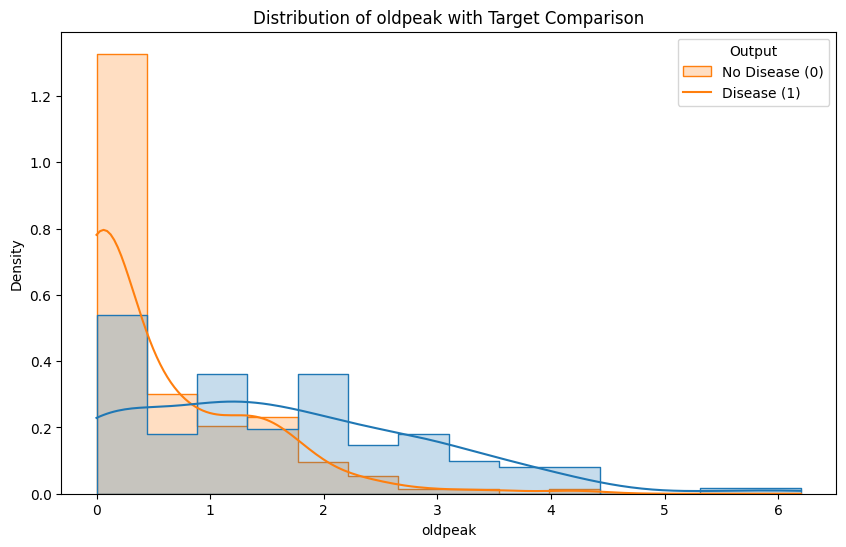

In [33]:
# Define your continuous columns
continuous_cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']

# Loop through continuous columns and create a separate graph for each
for col in continuous_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df, x=col, hue='output', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {col} with Target Comparison')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend(title='Output', labels=['No Disease (0)', 'Disease (1)'])
    plt.show()

In [34]:
'''plt.figure(figsize=(20,20))
sns.pairplot(df)
plt.show()'''

'plt.figure(figsize=(20,20))\nsns.pairplot(df)\nplt.show()'

In [35]:
# creating a copy of df
df1 = df

# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

# encoding the categorical columns
df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

# defining the features and target
X = df1.drop(['output'],axis=1)
y = df1[['output']]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[con_cols] = scaler.fit_transform(X[con_cols])

In [36]:
X= X.replace(False,0)
X= X.replace(True,1)

X.head()

age  trtbps      chol  thalachh  oldpeak  sex_1  exng_1  caa_1  caa_2  \
0  0.592593    0.75 -0.110236 -0.092308   0.9375      1       0      0      0   
1 -1.333333    0.00  0.157480  1.046154   1.6875      1       0      0      0   
2 -1.037037    0.00 -0.566929  0.584615   0.3750      0       0      0      0   
3  0.074074   -0.50 -0.062992  0.769231   0.0000      1       0      0      0   
4  0.148148   -0.50  1.795276  0.307692  -0.1250      0       1      0      0   

   caa_3  ...  cp_2  cp_3  fbs_1  restecg_1  restecg_2  slp_1  slp_2  thall_1  \
0      0  ...     0     1      1          0          0      0      0        1   
1      0  ...     1     0      0          1          0      0      0        0   
2      0  ...     0     0      0          0          0      0      1        0   
3      0  ...     0     0      0          1          0      0      1        0   
4      0  ...     0     0      0          1          0      0      1        0   

   thall_2  thall_3  
0        0        0  
1        1        0  
2        1        0  
3        1        0  
4        1        0  

[5 rows x 22 columns]

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
print("The shape of X_train is      ", X_train.shape)
print("The shape of X_test is       ",X_test.shape)
print("The shape of y_train is      ",y_train.shape)
print("The shape of y_test is       ",y_test.shape)

The shape of X_train is       (242, 22)
The shape of X_test is        (61, 22)
The shape of y_train is       (242, 1)
The shape of y_test is        (61, 1)


In [4]:
df_new = pd.read_csv("C:\\Users\\pcata\\OneDrive\\Ambiente de Trabalho\\heart_additional.csv")
df = pd.read_csv("heart.csv")

# Data Units test

In [8]:
df_new

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
398   34    0   1     133   468    0        0        91     0      3.0    0   
399   59    0   0     137   455    0        1       186     0      2.0    1   
400   47    0   2     112   546    0        0       198     0      3.0    0   
401   58    0   0     119   284    0        0       146     0      0.0    0   
402   34    0   0     114   552    0        1       122     0      4.0    0   

     caa  thall  output  
0      0      1       1  
1      0      2       1  
2      0      2       1  
3      0      2       1  
4      0      2       1  
..   ...    ...     ...  
398    0      2       0  
399    0      2       0  
400    3      2       0  
401    0      2       0  
402    0      2       0  

[403 rows x 14 columns]

In [10]:
df

age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0     63    1   3     145   233    1        0       150     0      2.3    0   
1     37    1   2     130   250    0        1       187     0      3.5    0   
2     41    0   1     130   204    0        0       172     0      1.4    2   
3     56    1   1     120   236    0        1       178     0      0.8    2   
4     57    0   0     120   354    0        1       163     1      0.6    2   
..   ...  ...  ..     ...   ...  ...      ...       ...   ...      ...  ...   
298   57    0   0     140   241    0        1       123     1      0.2    1   
299   45    1   3     110   264    0        1       132     0      1.2    1   
300   68    1   0     144   193    1        1       141     0      3.4    1   
301   57    1   0     130   131    0        1       115     1      1.2    1   
302   57    0   1     130   236    0        0       174     0      0.0    1   

     caa  thall  output  
0      0      1       1  
1      0      2       1  
2      0      2       1  
3      0      2       1  
4      0      2       1  
..   ...    ...     ...  
298    0      3       0  
299    0      3       0  
300    2      3       0  
301    1      3       0  
302    1      2       0  

[303 rows x 14 columns]

# Data Preprocessing
Scalling --> RobustScaler if we have outliers and non-normal distributions // StandartScaler When your data is normally distributed (i.e., follows a Gaussian distribution).
When your data does not contain significant outliers.

In [13]:
df_transformed = df.drop_duplicates()
df_transformed.describe().to_dict()

{'age': {'count': 302.0,
  'mean': 54.420529801324506,
  'std': 9.047969746247464,
  'min': 29.0,
  '25%': 48.0,
  '50%': 55.5,
  '75%': 61.0,
  'max': 77.0},
 'sex': {'count': 302.0,
  'mean': 0.6821192052980133,
  'std': 0.466425738067264,
  'min': 0.0,
  '25%': 0.0,
  '50%': 1.0,
  '75%': 1.0,
  'max': 1.0},
 'cp': {'count': 302.0,
  'mean': 0.9635761589403974,
  'std': 1.0320436419542325,
  'min': 0.0,
  '25%': 0.0,
  '50%': 1.0,
  '75%': 2.0,
  'max': 3.0},
 'trtbps': {'count': 302.0,
  'mean': 131.60264900662253,
  'std': 17.56339423003756,
  'min': 94.0,
  '25%': 120.0,
  '50%': 130.0,
  '75%': 140.0,
  'max': 200.0},
 'chol': {'count': 302.0,
  'mean': 246.5,
  'std': 51.75348865574056,
  'min': 126.0,
  '25%': 211.0,
  '50%': 240.5,
  '75%': 274.75,
  'max': 564.0},
 'fbs': {'count': 302.0,
  'mean': 0.1490066225165563,
  'std': 0.3566860293648133,
  'min': 0.0,
  '25%': 0.0,
  '50%': 0.0,
  '75%': 0.0,
  'max': 1.0},
 'restecg': {'count': 302.0,
  'mean': 0.5264900662251656,


In [15]:
ingested = pd.concat([df, df_new], ignore_index=False)
ingested = ingested.reset_index(drop=True).reset_index()

# data split

In [18]:
ref_heart = ingested.sample(frac=0.8,random_state=42)
ana_heart = ingested.drop(ref_heart.index)

# feature eng

In [21]:
def create_feat(df):
    age_bins = [0, 30, 50, 65, 80, 100, 115]
    bp_bins = [0, 120, 140, 160, 180, 200]

    df['age_bin'] = pd.cut(df['age'], bins=age_bins, labels=['0-30', '31-50', '50-65', '65-80', '80-100', '100-115'])
    df['bp_bin'] = pd.cut(df['trtbps'], bins=bp_bins, labels=['0-120', '121-140', '141-160', '161-180', '181-200'])

    # Creating the profile identifier
    df['profile'] = df['age_bin'].astype(str) + '_' + df['bp_bin'].astype(str)

    # Apply Z-score normalization to the cholesterol column
    df['chol_zscore'] = zscore(df['chol'])
    df = df.drop(columns=['profile', 'age_bin', 'bp_bin'])
    return df

#fazer data units

def encode_and_scale(df: pd.DataFrame) -> pd.DataFrame:
    cat_cols = ['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']
    con_cols = ["age", "trtbps", "chol", "thalachh", "oldpeak", "chol_zscore"]

    # Encoding the categorical columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    df = df.replace({False: 0, True: 1})
    # Scaling the continuous columns
    scaler = StandardScaler()
    df[con_cols] = scaler.fit_transform(df[con_cols])
    
    logging.info(f"Data after encoding and scaling has {df.shape[1]} columns.")
    return df

def feature_engineer(df: pd.DataFrame):
    df = create_feat(df)
    df = encode_and_scale(df)
    #oh = df.loc[:,['sex', 'exng', 'caa', 'cp', 'fbs', 'restecg', 'slp', 'thall']]
    return df

In [23]:
preprocess_train_data = feature_engineer(ref_heart)

2024-06-30 15:35:38,611 INFO: Data after encoding and scaling has 25 columns.


In [25]:
preprocess_train_data

index       age    trtbps      chol  thalachh   oldpeak  output  \
478    478 -1.433188 -1.167125 -1.232504 -1.227218  0.562289       0   
81      81 -0.928922 -0.309800  0.578337  0.837944 -0.923301       1   
77      77  0.483025  0.261750 -0.538990  0.616677 -0.923301       1   
208    208 -0.525508 -0.690834 -0.962804 -0.305271  0.562289       0   
319    319  0.382172 -0.690834  0.989308  0.911700 -0.923301       1   
..     ...       ...       ...       ...       ...       ...     ...   
347    347 -1.534042  0.261750  0.745294  1.280479 -0.923301       1   
505    505  0.382172  0.738041  0.090309 -1.337852 -0.329065       0   
694    694 -1.534042  2.214545  2.158007 -1.190340 -0.180506       0   
651    651  1.491558 -0.690834  2.491920  0.247898  1.305084       0   
634    634  0.483025  1.833512  1.207636  1.944281 -0.180506       0   

     chol_zscore  sex_1  exng_1  ...  cp_2  cp_3  fbs_1  restecg_1  restecg_2  \
478    -1.232504      1       1  ...     0     0      0          0          0   
81      0.578337      1       0  ...     0     0      0          0          0   
77     -0.538990      1       1  ...     0     0      0          1          0   
208    -0.962804      1       0  ...     1     0      0          1          0   
319     0.989308      0       0  ...     1     0      0          1          0   
..           ...    ...     ...  ...   ...   ...    ...        ...        ...   
347     0.745294      1       0  ...     1     0      0          0          0   
505     0.090309      1       1  ...     0     0      0          0          0   
694     2.158007      0       0  ...     0     0      0          1          0   
651     2.491920      0       0  ...     0     0      0          1          0   
634     1.207636      0       0  ...     0     0      0          1          0   

     slp_1  slp_2  thall_1  thall_2  thall_3  
478      1      0        0        0        1  
81       0      1        0        1        0  
77       0      1        0        1        0  
208      1      0        0        0        1  
319      0      1        0        1        0  
..     ...    ...      ...      ...      ...  
347      0      1        0        1        0  
505      0      1        0        0        1  
694      0      0        0        1        0  
651      1      0        1        0        0  
634      1      0        0        1        0  

[565 rows x 25 columns]

# split train

In [28]:
def split_data(
    data):
    """Splits data into features and target training and test sets.

    Args:
        data: Data containing features and target.
        parameters: Parameters defined in parameters.yml.
    Returns:
        Split data.
    """


    y = data['output']
    X = data.drop(columns='output', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test

In [30]:
X_train, X_test, y_train, y_test = split_data(preprocess_train_data)
print(X_train)

     index       age    trtbps      chol  thalachh   oldpeak  chol_zscore  \
701    701 -2.038308 -0.071654  2.633192 -2.075410  1.305084     2.633192   
199    199  1.088145 -1.167125 -0.192233  0.395409 -0.477624    -0.192233   
590    590  0.281318  0.928558 -0.397719  0.616677 -0.923301    -0.397719   
682    682  2.096678 -0.595575  2.761620 -2.776090  0.562289     2.761620   
472    472 -0.122095  0.261750 -0.770161  0.284776  1.379364    -0.770161   
..     ...       ...       ...       ...       ...       ...          ...   
409    409  1.491558  1.214333 -0.372033 -0.600294 -0.849021    -0.372033   
499    499 -0.828068  0.738041 -0.410562 -0.010247  1.750761    -0.410562   
165    165  1.289852  1.214333  0.295795 -1.448486  0.190892     0.295795   
29      29 -0.122095 -0.214542 -0.847218  0.174142 -0.031947    -0.847218   
432    432  1.995825 -0.690834  0.077466 -0.969073 -0.774742     0.077466   

     sex_1  exng_1  caa_1  ...  cp_2  cp_3  fbs_1  restecg_1  restecg_2  \


# feature selection

In [33]:
import random
random.seed(42)
np.random.seed(42)
def feature_selection(X_train: pd.DataFrame, y_train: pd.Series) -> list:
    import random
    from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif
    import logging
    import numpy as np
    import pandas as pd
    

    log = logging.getLogger(__name__)
    log.info(f"We start with: {len(X_train.columns)} columns")

    # Remove 'index' column if it exists in X_train
    if 'index' in X_train.columns:
        X_train = X_train.drop(columns=['index'])
        log.info(f"Removed 'index' column from X_train. Now we have: {len(X_train.columns)} columns")
    
    # Step 1: Apply Variance Threshold
    vth = VarianceThreshold(threshold=0)
    X_train_vth = X_train.iloc[:, vth.fit(X_train).get_support()]
    
    # Step 2: Apply SelectKBest (ANOVA F-value)
    Kbest_classif = SelectKBest(score_func=f_classif, k='all')
    Kbest_classif.fit(X_train_vth, y_train)
    f_scores = Kbest_classif.scores_
    
    # Step 3: Apply SelectKBest (mutual information)
    infogain_classif = SelectKBest(score_func=mutual_info_classif, k='all')
    infogain_classif.fit(X_train_vth, y_train)
    mi_scores = infogain_classif.scores_
    
    # Step 4: Normalize scores
    f_scores_norm = (f_scores - np.min(f_scores)) / (np.max(f_scores) - np.min(f_scores))
    mi_scores_norm = (mi_scores - np.min(mi_scores)) / (np.max(mi_scores) - np.min(mi_scores))
    
    # Step 5: Combine scores
    combined_scores = f_scores_norm + mi_scores_norm
    
    # Create a DataFrame for the combined scores
    scores_df = pd.DataFrame({
        'Feature': X_train_vth.columns,
        'F_score': f_scores,
        'MI_score': mi_scores,
        'Combined_score': combined_scores
    }).sort_values('Combined_score', ascending=False)
    
    X_cols = scores_df['Feature'].head(10).tolist()
    
    # Log the number of selected features and their names
    print(f"Number of best columns is: {len(X_cols)}")
    print(f"Selected features: {X_cols}")
    
    return X_cols

In [35]:
features=feature_selection(X_train, y_train)
print(features)

2024-06-30 15:35:40,003 INFO: We start with: 24 columns
2024-06-30 15:35:40,005 INFO: Removed 'index' column from X_train. Now we have: 23 columns
Number of best columns is: 10
Selected features: ['thall_2', 'oldpeak', 'slp_2', 'thalachh', 'chol_zscore', 'chol', 'cp_2', 'slp_1', 'exng_1', 'caa_1']
['thall_2', 'oldpeak', 'slp_2', 'thalachh', 'chol_zscore', 'chol', 'cp_2', 'slp_1', 'exng_1', 'caa_1']


# model train

In [70]:

def model_train(X_train: pd.DataFrame, 
                X_test: pd.DataFrame, 
                y_train: pd.DataFrame, 
                y_test: pd.DataFrame,
               best_columns):
    
    logger = logging.getLogger(__name__)
    models_dict = {
        'RandomForestClassifier': RandomForestClassifier(random_state=42),
        'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
        'LogisticRegression': LogisticRegression(random_state=42, max_iter=50, C=1, penalty="l2", solver="liblinear"),
    }

    model_name = random.choice(list(models_dict.keys()))
    logger.info(model_name)
    classifier = models_dict[model_name]

    results_dict = {}

    # Start MLflow run

    logger.info("Using feature selection in model train...")
    X_train = X_train[best_columns]
    X_test = X_test[best_columns]
    model = classifier.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Calculate metrics
    accuracy_val = accuracy_score(y_test, y_test_pred)
    precision_val = precision_score(y_test, y_test_pred, average='weighted')
    recall_val = recall_score(y_test, y_test_pred, average='weighted')
    f1_val = f1_score(y_test, y_test_pred, average='weighted')

    # Log metrics


    logger.info(model_name)
    logger.info("Model accuracy on test set: %0.4f%%", accuracy_val * 100)
    logger.info("Model precision on test set: %0.4f%%", precision_val * 100)
    logger.info("Model recall on test set: %0.4f%%", recall_val * 100)
    logger.info("Model F1 score on test set: %0.4f%%", f1_val * 100)

    results_dict['classifier'] = classifier.__class__.__name__
    results_dict['test_score'] = [accuracy_val,precision_val,recall_val,f1_val]



In [72]:
model_train(X_train,X_test,y_train,y_test,features)

2024-06-30 15:42:36,160 INFO: RandomForestClassifier
2024-06-30 15:42:36,161 INFO: Using feature selection in model train...
2024-06-30 15:42:36,538 INFO: RandomForestClassifier
2024-06-30 15:42:36,539 INFO: Model accuracy on test set: 91.1504%
2024-06-30 15:42:36,540 INFO: Model precision on test set: 91.3955%
2024-06-30 15:42:36,541 INFO: Model recall on test set: 91.1504%
2024-06-30 15:42:36,542 INFO: Model F1 score on test set: 91.1588%


# Model selection

In [50]:
import logging
import mlflow
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score

logger = logging.getLogger(__name__)

def model_selection(X_train: pd.DataFrame, 
                    X_test: pd.DataFrame, 
                    y_train: pd.DataFrame, 
                    y_test: pd.DataFrame,
                    best_columns):
    """
    Trains models using the provided training data and performs hyperparameter tuning.
    Returns the GridSearchCV results for all models.

    Args:
    --
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Test features.
        y_train (pd.DataFrame): Training target.
        y_test (pd.DataFrame): Test target.
        best_columns (list): List of selected feature columns.

    Returns:
    --
        dict: A dictionary containing GridSearchCV results for each model.
    """
    
    # Select the specified columns
    X_train = X_train[best_columns]
    X_test = X_test[best_columns]

    # Define the models to be trained
    models_dict = {
        'RandomForestClassifier': RandomForestClassifier(),
        'DecisionTreeClassifier': DecisionTreeClassifier(),
        'LogisticRegression': LogisticRegression(),  # Ensure convergence with higher max_iter
    }

    # Define the hyperparameters for each model
    parameters = {
        'hyperparameters': {
            'RandomForestClassifier': {
                'n_estimators': [100, 200, 300],
                'max_depth': [5, 10, 20],
                'max_features': [0.5, 0.7, 1.0],
                'random_state': [42]
            },
            'DecisionTreeClassifier': {
                'criterion': ["gini", "entropy"],
                'splitter': ["best", "random"],
                'max_depth': [5, 10, 20],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': [None, "auto", "sqrt", "log2"],
                'random_state': [42]
            },
            'LogisticRegression': {
                'penalty': ["l1", "l2", "elasticnet", "none"],
                'C': [0.01, 0.1, 1, 10, 100],
                'solver': ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
                'random_state': [42],
                'max_iter': [50, 100, 150]
            }
        }
    }

    logger.info('Starting model selection: Comparing between model types')

    # Convert y_train and y_test to 1D arrays
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    results = {}

    with mlflow.start_run(nested=True):
        for model_name, model in models_dict.items():
            logger.info(f"Performing GridSearchCV for {model_name}")

            # Perform hyperparameter tuning with GridSearchCV
            param_grid = parameters['hyperparameters'].get(model_name, {})
            logger.info(f"Parameter grid for {model_name}: {param_grid}")
            gridsearch = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
            gridsearch.fit(X_train, y_train)

            # Get the best parameters and best score from GridSearchCV
            best_params = gridsearch.best_params_
            best_score = gridsearch.best_score_

            # Calculate accuracy and F1-score on the test set using the best model
            best_model = gridsearch.best_estimator_
            y_pred = best_model.predict(X_test)
            test_accuracy = accuracy_score(y_test, y_pred)
            test_f1_score = f1_score(y_test, y_pred, average='weighted')

            logger.info(f"{model_name} best parameters: {best_params}")
            logger.info(f"{model_name} best cross-validated score: {best_score}")
            logger.info(f"{model_name} test score -> accuracy: {test_accuracy}, f1-score: {test_f1_score}")

            # Store the results in the dictionary
            results[model_name] = {
                'best_model': best_model,
                'best_params': best_params,
                'best_cv_score': best_score,
                'test_accuracy': test_accuracy,
                'test_f1_score': test_f1_score,
                'gridsearch_results': gridsearch.cv_results_
            }

    return results



In [52]:
model_selection(X_train, X_test, y_train, y_test,features )

2024-06-30 15:38:24,689 INFO: Starting model selection: Comparing between model types
2024-06-30 15:38:24,815 INFO: Performing GridSearchCV for RandomForestClassifier
2024-06-30 15:38:24,816 INFO: Parameter grid for RandomForestClassifier: {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 20], 'max_features': [0.5, 0.7, 1.0], 'random_state': [42]}
2024-06-30 15:38:47,521 INFO: RandomForestClassifier best parameters: {'max_depth': 20, 'max_features': 0.5, 'n_estimators': 200, 'random_state': 42}
2024-06-30 15:38:47,524 INFO: RandomForestClassifier best cross-validated score: 0.8871306471306472
2024-06-30 15:38:47,525 INFO: RandomForestClassifier test score -> accuracy: 0.9380530973451328, f1-score: 0.9381113865972193
2024-06-30 15:38:47,526 INFO: Performing GridSearchCV for DecisionTreeClassifier
2024-06-30 15:38:47,526 INFO: Parameter grid for DecisionTreeClassifier: {'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'max_depth': [5, 10, 20], 'min_samples_split': [

{'RandomForestClassifier': {'best_model': RandomForestClassifier(max_depth=20, max_features=0.5, n_estimators=200,
                         random_state=42),
  'best_params': {'max_depth': 20,
   'max_features': 0.5,
   'n_estimators': 200,
   'random_state': 42},
  'best_cv_score': 0.8871306471306472,
  'test_accuracy': 0.9380530973451328,
  'test_f1_score': 0.9381113865972193,
  'gridsearch_results': {'mean_fit_time': array([1.13230491, 1.97407708, 3.01966333, 1.10129337, 2.51884737,
          3.20439029, 1.34405932, 2.51400132, 3.9482337 , 1.13589568,
          2.32043777, 3.08714285, 1.18236313, 2.54896927, 3.64205332,
          1.41988549, 3.00558424, 4.26346855, 1.10680504, 2.15448251,
          3.31346307, 1.30121665, 2.49530683, 3.70565224, 1.43103695,
          2.6273283 , 2.64447675]),
   'std_fit_time': array([0.16718443, 0.10468519, 0.14657197, 0.15622033, 0.20284268,
          0.26345805, 0.09846299, 0.08485145, 0.29144282, 0.16323739,
          0.27305264, 0.22302291, 0.1

Feature Importances (sorted):
thall_2      0.094 +/- 0.022
oldpeak      0.051 +/- 0.017
slp_2        0.044 +/- 0.022
thalachh     0.027 +/- 0.015
cp_3         0.019 +/- 0.006
caa_2        0.015 +/- 0.004
age          0.014 +/- 0.006
sex_1        0.011 +/- 0.006
chol         0.009 +/- 0.009
caa_1        0.007 +/- 0.008
trtbps       0.007 +/- 0.011
chol_zscore  0.004 +/- 0.007
thall_3      0.000 +/- 0.000
caa_3        0.000 +/- 0.000
cp_1         0.000 +/- 0.000
fbs_1        0.000 +/- 0.000
restecg_1    0.000 +/- 0.000
restecg_2    0.000 +/- 0.000
slp_1        0.000 +/- 0.000
thall_1      0.000 +/- 0.000
caa_4        0.000 +/- 0.000
cp_2         -0.012 +/- 0.011
exng_1       -0.017 +/- 0.007


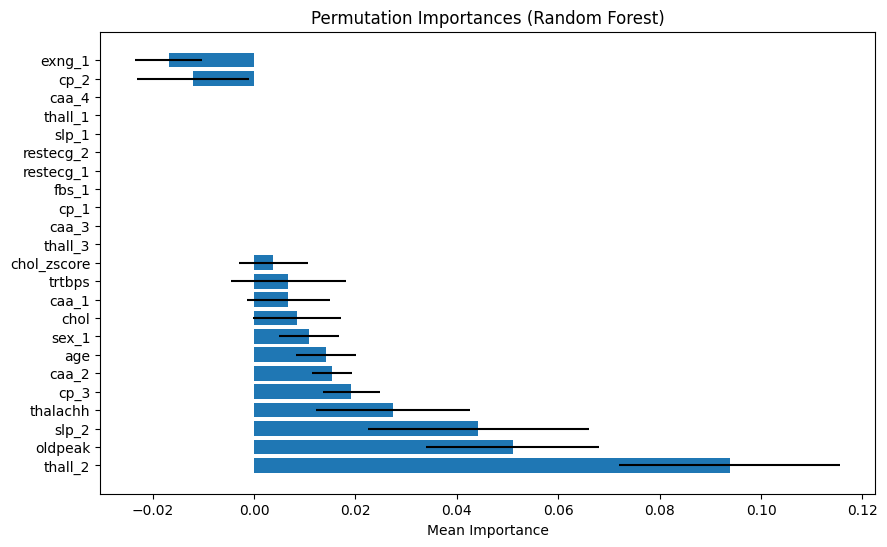

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed
# Drop the 'index' column from both X_train and X_test if it exists
if 'index' in X_train.columns:
    X_train_clean = X_train.drop(columns=["index"])
else:
    X_train_clean = X_train

if 'index' in X_test.columns:
    X_test_clean = X_test.drop(columns=["index"])
else:
    X_test_clean = X_test

# Train the RandomForest model on the cleaned training set
rf = RandomForestClassifier(max_depth=20, max_features=0.5, n_estimators=200, random_state=42)
rf.fit(X_train_clean, y_train)

# Compute permutation importance on the cleaned test set
r = permutation_importance(rf, X_test_clean, y_test, n_repeats=30, random_state=42)

# Get sorted indices based on mean importance
sorted_idx = r.importances_mean.argsort()

# Print and plot feature importances in order
print("Feature Importances (sorted):")
for i in sorted_idx[::-1]:
    print(f"{X_train_clean.columns[i]:<12} "
          f"{r.importances_mean[i]:.3f} "
          f"+/- {r.importances_std[i]:.3f}")

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), r.importances_mean[sorted_idx], xerr=r.importances_std[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [X_train_clean.columns[i] for i in sorted_idx])
plt.xlabel('Mean Importance')
plt.title('Permutation Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()


In [81]:
X_test

index       age    trtbps      chol  thalachh   oldpeak  chol_zscore  \
326    326  0.684732  0.738041 -0.256448 -0.379027 -0.180506    -0.256448   
675    675 -0.122095  2.357433  1.734193 -0.969073 -0.180506     1.734193   
30      30 -1.332335 -1.405271 -0.834376  0.764188 -0.923301    -0.834376   
176    176  0.583878 -0.833721 -0.423405  0.469165  0.116612    -0.423405   
283    283 -1.433188  0.833300 -0.513305  1.243601 -0.923301    -0.513305   
..     ...       ...       ...       ...       ...       ...          ...   
633    633  0.281318  2.262174  0.668237 -0.452782  1.305084     0.668237   
344    344 -0.626362 -0.214542 -0.230762  1.206723 -0.774742    -0.230762   
534    534  0.281318  1.452479  0.334323 -0.858439 -0.180506     0.334323   
50      50 -0.323802 -0.214542 -0.089491  0.063508 -0.551903    -0.089491   
404    404  0.483025  2.071658  0.090309 -0.084003  2.196438     0.090309   

     sex_1  exng_1  caa_1  ...  cp_2  cp_3  fbs_1  restecg_1  restecg_2  \
326      1       1      0  ...     1     0      1          1          0   
675      0       0      0  ...     1     0      0          1          0   
30       0       0      1  ...     0     0      0          1          0   
176      1       1      0  ...     0     0      1          1          0   
283      1       0      0  ...     0     0      0          1          0   
..     ...     ...    ...  ...   ...   ...    ...        ...        ...   
633      0       0      0  ...     0     0      0          0          0   
344      1       0      0  ...     0     0      0          0          0   
534      1       0      0  ...     0     0      1          0          0   
50       0       0      0  ...     1     0      0          0          0   
404      1       0      0  ...     0     1      0          0          0   

     slp_1  slp_2  thall_1  thall_2  thall_3  
326      1      0        0        1        0  
675      0      0        0        1        0  
30       0      1        0        1        0  
176      0      1        0        0        1  
283      0      1        0        0        1  
..     ...    ...      ...      ...      ...  
633      1      0        0        0        0  
344      1      0        0        1        0  
534      1      0        0        0        1  
50       0      1        0        1        0  
404      0      0        0        0        1  

[113 rows x 24 columns]

In [89]:
y_test.dtypes

dtype('int64')